In [1]:
import rdkit
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
#IPythonConsole.ipython_useSVG=True\
from captum.attr import *
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils import accuracy, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling, GCNConv, EdgePooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from sklearn.model_selection import train_test_split


from visualize import visualize
from Network import Net
from commons import SEEN_ATOMS, atoms, try_catch, gen_graph

RDKit WARNING: [11:08:45] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

device = 'cpu'

In [3]:
df = pd.read_csv('datasets/covid_chembl_1700.csv', header = 0, sep=';')
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
0,CHEMBL416230,DECOQUINATE,0,417.55,1,6.04,decoquinate,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
1,CHEMBL556,DEFEROXAMINE,4,560.69,2,0.92,Deferoxamine,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
2,CHEMBL1200980,ESTROPIPATE,4,436.57,0,3.29,estropipate,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
3,CHEMBL173562,NaN,0,182.17,0,0.54,2-hydroxyethyl-salicylate,O=C(OCCO)c1ccccc1O,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
4,CHEMBL4303162,NaN,0,None,None,None,7de5b5c6-cb03-4f69-b32d-738c306fa726,NaN,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,CHEMBL1337,NITISINONE,4,329.23,0,2.73,Nitisinone,O=C1CCCC(=O)C1C(=O)c1ccc(C(F)(F)F)cc1[N+](=O)[O-],Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
1665,CHEMBL620,CLIDINIUM,4,352.45,0,2.70,clidinium,C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
1666,CHEMBL566,URACIL,3,112.09,0,-0.94,Uracil,O=c1cc[nH]c(=O)[nH]1,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839
1667,CHEMBL114655,NYLIDRIN,0,299.41,0,3.43,Nylidrin,CC(CCc1ccccc1)NC(C)C(O)c1ccc(O)cc1,Hit score,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839


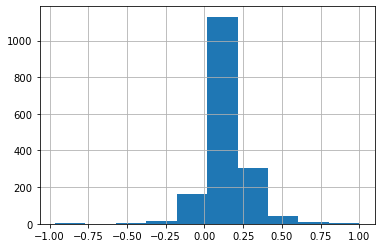

In [4]:
df['Standard Value'].hist()

In [5]:
import matplotlib.pyplot as plt
#plt.hist(df.pIC50)
#df['act'] = (df.pIC50 > 8.2)*1.0
#df['act'] = (df.logP >= 1) & (df['logP'] <= 4 )
df['act'] = df['Standard Value']
df['SMILES'] = df.Smiles

In [6]:
df.head(5)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,act,SMILES
0,CHEMBL416230,DECOQUINATE,0,417.55,1,6.04,decoquinate,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC,Hit score,'=',...,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.058900,CCCCCCCCCCOc1cc2c(O)c(C(=O)OCC)cnc2cc1OCC
1,CHEMBL556,DEFEROXAMINE,4,560.69,2,0.92,Deferoxamine,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,Hit score,'=',...,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,-0.000062,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...
2,CHEMBL1200980,ESTROPIPATE,4,436.57,0,3.29,estropipate,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...,Hit score,'=',...,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.146400,C1CNCCN1.C[C@]12CC[C@@H]3c4ccc(OS(=O)(=O)O)cc4...
3,CHEMBL173562,NaN,0,182.17,0,0.54,2-hydroxyethyl-salicylate,O=C(OCCO)c1ccccc1O,Hit score,'=',...,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.157000,O=C(OCCO)c1ccccc1O
4,CHEMBL4303162,NaN,0,None,None,None,7de5b5c6-cb03-4f69-b32d-738c306fa726,NaN,Hit score,'=',...,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303122,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4303839,0.019940,NaN


In [7]:
df['mol'] = df.apply(lambda row: try_catch(Chem.MolFromSmiles, row['SMILES']), axis=1)
df = df.dropna(subset=['mol'])
df['graph'] = df.apply(lambda row: gen_graph(row['mol'], row['act']), axis=1)

No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float nan
No registered conver

/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_train, df_test = train_test_split(df, shuffle=True)
df_train = df
df_test = df

In [9]:
train_data = list(df_train.graph)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_data = list(df_test.graph)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [10]:
net = Net(19+len(atoms), device=device)
net = net.to(device)
#loss = nn.BCELoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
EPOCHS = 70

In [11]:
losses = []
print('loss, acc, f1')
for epoch in range(EPOCHS):
    net.train()
    stats = np.zeros(3)
    for data in train_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        y_pred = net(x, edge_index, batch)
        y = data.y.to(device)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        stats += data.num_graphs * np.array([l.item(), 0, 0])
#         stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
        #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])

    losses.append(stats/len(train_data))
    print('train', losses[-1])
    net.eval()
    stats = np.zeros(3)
    for data in test_loader:
        with torch.no_grad():
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            y_pred = net(x, edge_index, batch)
            y = data.y.to(device)
            l = loss(y_pred, y)
            stats += data.num_graphs * np.array([l.item(), 0, 0])
#             stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
            #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
    losses.append(stats/len(test_data))
    print('test', losses[-1])

loss, acc, f1
train [3.79349569 0.         0.        ]
test [0.18319546 0.         0.        ]
train [0.62395084 0.         0.        ]
test [0.30263469 0.         0.        ]
train [0.19422594 0.         0.        ]
test [0.1317481 0.        0.       ]
train [0.07592721 0.         0.        ]
test [0.08274075 0.         0.        ]
train [0.05183695 0.         0.        ]
test [0.04996123 0.         0.        ]
train [0.03500922 0.         0.        ]
test [0.03598821 0.         0.        ]
train [0.02889969 0.         0.        ]
test [0.02850686 0.         0.        ]
train [0.02591724 0.         0.        ]
test [0.02474246 0.         0.        ]
train [0.02345399 0.         0.        ]
test [0.02246041 0.         0.        ]
train [0.02194375 0.         0.        ]
test [0.02191705 0.         0.        ]
train [0.02146776 0.         0.        ]
test [0.02136064 0.         0.        ]
train [0.02094977 0.         0.        ]
test [0.02092832 0.         0.        ]
train [0.02075419

In [12]:
net

Net(
  (atom_embedding): Linear(in_features=50, out_features=50, bias=True)
  (conv1): GCNConv(50, 50)
  (pool1): EdgePooling(50)
  (conv2): GCNConv(50, 50)
  (pool2): EdgePooling(50)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [13]:
torch.save(net, 'models/gt_model_covid')
#net = torch.load('models/gt_model')

In [14]:
METHODS = {
        "Integrated Gradients": IntegratedGradients,
        "Deep Lift": DeepLift,
        "Gradients": Saliency,
        "Input X Gradients": InputXGradient,
        "Guided Backprop": GuidedBackprop,
    }
#MOLS = ['CC(C)=CCCC(C)=CC(=O)', 'CC(O)=CCCC(C)=CC=O', 'CC(C)=CCCC(C)=CC']
MOLS = ['CCCCC', 'CCCCO', 'OC(=O)CCCCO']
MOLS = [df.Smiles[5], df.Smiles[1666]]
explainations = {}
for name, method in METHODS.items():
    imgs = visualize(MOLS, net, method, device=device)
    explainations[name] = imgs

/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/home/alessio/miniconda3/envs/torch/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


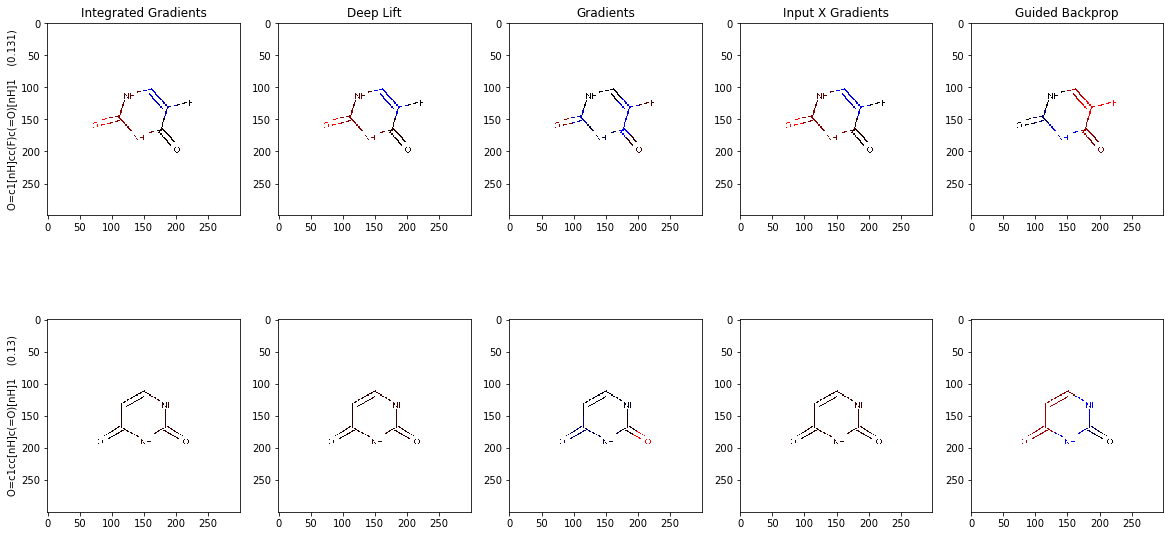

In [15]:
fig, ax = plt.subplots(len(MOLS), len(METHODS), figsize=(10*len(MOLS), 2*len(METHODS)))

for i, (name, imgs) in enumerate(explainations.items()):
    for j, (img, act) in enumerate(imgs):
        ax[j,i].imshow(img)
        ax[j,0].set_ylabel(f"{MOLS[j]}    ({act:.3})")
    ax[0,i].set_title(name)

plt.show()